# Tutorial on regression techniques
### [Workshop on Reduced Order Gravitational-Wave Modeling](https://workshops.aei.mpg.de/gw-rom-roq/) (Wednesday June 20, 2018 at 11:30)

Regression/fitting is used in many aspects of gravitational-wave modeling from building fast surrogate models to tuning the free parameters of analytic models using numerical simulations. 

This tutorial covers linear models (Ridge, Lasso), kernel techniques (Kernel Ridge, Support Vector Regression, Gaussian Process Regression), Neural Networks, and tree-based fitting (Random Forest). The goal is to use regularization techniques and hyperparameter optimization to avoid overfitting.

I will be using [scikit-learn](http://scikit-learn.org/stable/index.html) which provides a common API for many regression techniques. It can be installed with

`pip install -U scikit-learn`

or something similar. See the [documentation](http://scikit-learn.org/stable/install.html).

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn import neural_network
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


# Simple 1d example

We will use points sampled from the following 1d function for all the regression methods below. I have added an artificial error term to represent numerical error in the original model.

In [2]:
# Set random seed so data is always the same
np.random.seed(3)
nsamp = 10

# The true function
def func(x):
    return 10.0*(np.sin(0.4*x*(1.0+0.03*x)) + 0.2*x + 1)

# Generate X values
# sklearn wants 2d data with shape (N_examples, N_features)
X_train = np.random.uniform(-10.0, 10.0, nsamp)
X_train = np.atleast_2d(X_train).T

# Generate y values and add a small amount of noise
sigma = 1.0
y_train = func(X_train[:, 0]) + np.random.normal(0.0, sigma, len(X_train))

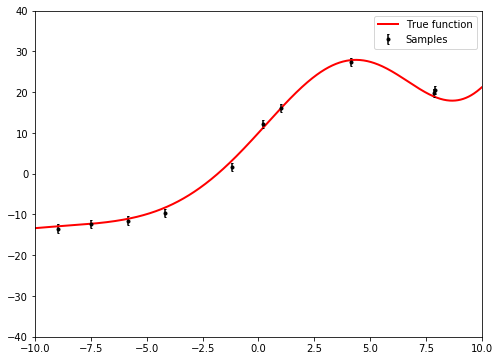

In [3]:
def plot_data(func, X_train, y_train, sigma):
    """Plot the true function and data.
    """
    fig, axes = plt.subplots(figsize=(8, 6))

    # True function
    xs = np.linspace(-10, 10, 1000)
    ys = func(xs)
    axes.plot(xs, ys, c='r', lw=2, label='True function')
    
    # Data with error bars
    axes.errorbar(X_train[:, 0], y_train, yerr=sigma, fmt=".k", capsize=1, label='Samples')

    axes.set_xlim(-10, 10)
    axes.set_ylim(-40, 40)
    axes.legend()
    
    return axes

axes = plot_data(func, X_train, y_train, sigma)

# Generalized linear models

A generalized linear model has the form

$\hat y_w(x) = w_0 + w_1 x_1 + \dots + w_n x_n$.

The $x_i$ are features or engineered features (e.g. products of features). 

Below, we will fit an 11th order polynomial (12 free parameters) with 10 data points. The system is technically underdetermined and clearly overfits the data, so the model won't generalize to new data. Later, we will try regularization methods (Ridge and Lasso) to reduce the overfitting. Sklearn documentation is available [here](http://scikit-learn.org/stable/modules/linear_model.html).

The model below can be written as 

$\hat y_w(x) = w_0 + w_1 x + w_2 x^2 + \dots + w_{11} x^{11}$.

Each power is treated as a separate feature. All features are rescaled to the range [0, 1], which will be necessary later when using most regularization techniques. Feature scaling also generally helps optimizers.

In [4]:
# Create polynomial features
X_poly = np.array([[x, x**2, x**3, x**4, x**5, x**6, x**7, x**8, x**9, x**10, x**11] for x in X_train[:, 0]])

# Do feature scaling. Rescale all features to range [0, 1].
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_poly)
X_poly_scaled = scaler.transform(X_poly)

# The points where you will evaluate the fit
x_pred = np.linspace(-10, 10, 1000)
X_pred = np.array([[x, x**2, x**3, x**4, x**5, x**6, x**7, x**8, x**9, x**10, x**11] for x in x_pred])
X_pred_scaled = scaler.transform(X_pred)

## Linear regression without regularization

This is the most basic linear regression. The cost function that is minimized is the squared difference between the model $\hat y_w(x^i)$ and the data $y^i$:

$J(w) = \sum_{i=1}^m (\hat y_w^i-y^i)^2$.

The coefficients are large and the function is severely overfit.

In [5]:
reg = linear_model.LinearRegression()
reg.fit(X_poly_scaled, y_train)
y_pred = reg.predict(X_pred_scaled)

print 'w_0 = {}'.format(reg.intercept_)
print 'w_i = {}'.format(reg.coef_)

w_0 = -73.2882879135
w_i = [  113.37263254  -106.97101044  -370.20433088   710.65220322
  1161.27980883 -1320.96007581 -1020.20470268   598.17327028
  -827.85019957   178.94708823  1042.21689426]


/Users/lackey/Library/Python/2.7/lib/python/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


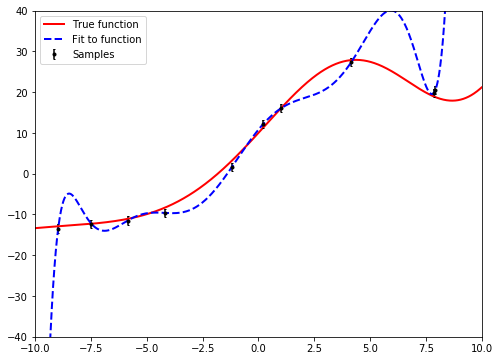

In [6]:
axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

## Ridge regression (linear regression with regularization)

Regularization is a method for penalizing large coefficients, and thus resulting in simpler fitting functions. The cost function that is minimized has an additional term for the coefficients, and looks like

$J(w) = \sum_{i=1}^m (\hat y_w^i-y^i)^2 + \alpha \sum_{j=1}^n w_j^2$.

The larger the hyperparameter $\alpha$ is, the smaller the coefficients will be that minimize the cost function. A nice blog post about regularization from the frequentist and Bayesian perspectives can be found [here](http://jakevdp.github.io/blog/2015/07/06/model-complexity-myth/).

**It is necessary to scale all features**. The regularization term only works properly if all features have similar numerical values. All features in the training set were rescaled above to lie in the range [0, 1].

### Example: varying the hyperparameter $\alpha$

Selecting the optimal hyperparameters is known as the bias-variance tradeoff.
 * A small regularization term allows large coefficients and overfitting. The resulting fit is complex and does not generalize to new data (high variance).
 * A large regularization term requires small coefficients. The resulting fit doesn't have enough complexity to capture the behavior of the data (high bias).
 * There is a happy medium that compromises between bias and variance.

alpha = 1e-06:
w_0 = -28.3918689581
w_i = [ 113.85173352  -13.24781001 -209.79571266   73.45252661  244.13395213
 -200.42089154 -133.47394217  125.29696567 -129.90633447   29.86640447
  169.80848689]

alpha = 0.001:
w_0 = -0.641369851721
w_i = [ 8.79738672e+01 -3.47475768e+00 -5.25947485e+01  4.82422749e+00
 -1.58421138e+01 -7.50314824e+00  4.38363087e-01 -6.75612006e+00
  4.14195085e+00  7.76554652e-02  2.25351790e+00]

alpha = 1:
w_0 = -11.3334377724
w_i = [15.90033862 -3.40766551  6.95024372 -1.08919358  3.934123    0.10570203
  2.50953969  0.66213409  1.66446487  0.90017082  1.08699997]

alpha = 1000:
w_0 = 4.99349986583
w_i = [ 0.04730495 -0.01251891  0.03387661 -0.01141353  0.02859884 -0.01148036
  0.02572836 -0.01217822  0.02385239 -0.01307957  0.02250587]



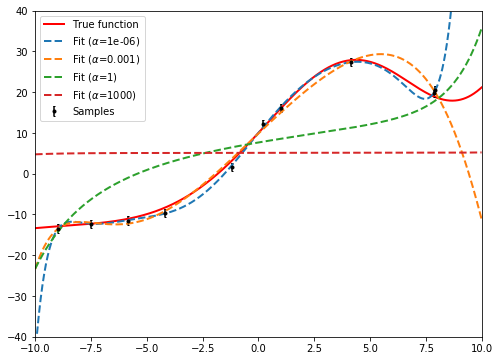

In [7]:
axes = plot_data(func, X_train, y_train, sigma)

for alpha in [10**-6, 10**-3, 1, 10**3]:
    # Do the fit with the chosen regularization parameter alpha
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(X_poly_scaled, y_train)
    print 'alpha = {}:\nw_0 = {}\nw_i = {}\n'.format(alpha, reg.intercept_, reg.coef_)
    
    # Plot the fit
    y_pred = reg.predict(X_pred_scaled)
    axes.plot(x_pred, y_pred, ls='--', lw=2, label=r'Fit ($\alpha$={})'.format(alpha))

axes.legend();

### Choosing the optimal hyperparameter $\alpha$ with cross-validation

k-fold cross-validation:
 1. Break training set into k sets.
 2. Train with k-1 sets. Calculate error with the other (validation) set.
 3. Cycle through the sets so that each set is the validation set exactly once.
 4. Choose the hyperparameters that give the smallest average error for the validation set.
 5. Retrain on the entire training set with the chosen hyperparameters.
 
Sklearn has several built-in methods for performing cross-validation and selecting the best hyperparameters.

In [8]:
# List of hyperparameters to try
alphas = np.logspace(-5, 2, 100)

# Do the fit for each value of alpha and for each train-validation split
reg = linear_model.RidgeCV(alphas=alphas, cv=5)
reg.fit(X_poly_scaled, y_train)

# Evaluate the fit at the desired points
y_pred = reg.predict(X_pred_scaled)

print 'w_0 = {}'.format(reg.intercept_)
print 'w_i = {}'.format(reg.coef_)
print 'Best value of alpha: {}'.format(reg.alpha_)

w_0 = -3.33470217727
w_i = [ 90.71342475  -3.48904977 -63.58494958   3.43177455 -12.98863471
  -9.84853531   5.60738249  -5.72465692   7.2851258    5.48763554
   2.12507189]
Best value of alpha: 0.000689261210435


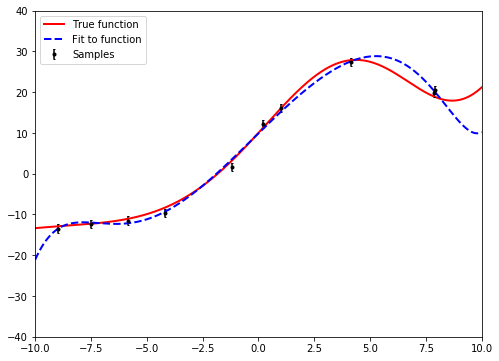

In [9]:
axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

## Lasso regression (another form of regularization)

Lasso uses a non-smooth $\mathcal{L}_1$ term for the regularization:

$J(w) = \sum_{i=1}^m (\hat y_w^i-y^i)^2 + \alpha \sum_{j=1}^n |w_j|$.

This sometimes causes the cost function to be minimized when some of the coefficients are 0. This amounts to model selection.

In [10]:
alphas = np.logspace(-5, 2, 100)
reg = linear_model.LassoCV(alphas=alphas, cv=5)
reg.fit(X_poly_scaled, y_train)
y_pred = reg.predict(X_pred_scaled)

print 'w_0 = {}'.format(reg.intercept_)
print 'w_i = {}'.format(reg.coef_)
print 'Best value of alpha: {}'.format(reg.alpha_)

w_0 = 0.148387203891
w_i = [ 90.29263568  -2.16450201 -64.69577505  -0.           0.
  -1.91101653   0.          -6.21199973   0.          -3.26935943
   0.        ]
Best value of alpha: 0.00486260158007


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


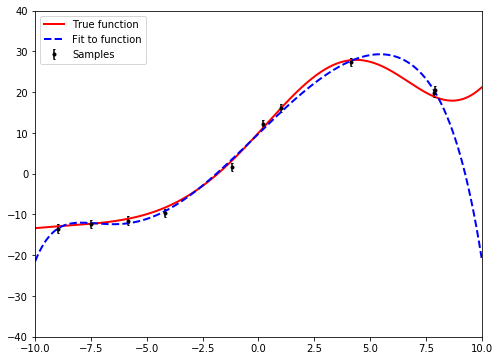

In [11]:
axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

## Other linear regression methods
There are many variations and alternatives (such as ElasticNet). See the [documentation](http://scikit-learn.org/stable/modules/linear_model.html) for ideas.

# Regression with kernels

The general form of a model expressed in terms of kernels is

$\hat y_w(x) = \sum_{i=1}^n w_i k(x, x_i)$.

Essentially, this is an extension of generalized linear regression with weights $w_i$ and features $k(x, x_i)$. This is sometimes known as the kernel trick. With this method there are as many features as data points.

There are many possible functional forms for the kernel, and the kernel may have several hyperparameters. The most common are radial basis function kernels that look something like this:

$k(x, x') = \exp(-\gamma r^2)$ where $r^2 = |x-x'|^2$.

The radial kernels in sklearn are isotropic (only have 1 radial scale parameter $\gamma$). So, for multivariate functions, they require all features to be scaled to roughly the same range. The exception is the Gaussian process regression module which has more generic kernels. 

In [12]:
# Do feature scaling. Rescale all features to range [0, 1].
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

# Do feature scaling on points you want to predict
x_pred = np.linspace(-10, 10, 1000)
X_pred = np.atleast_2d(x_pred).T
X_pred_scaled = scaler.transform(X_pred)

## Kernel ridge regression

This is the kernel analog of standard ridge regression. The cost function and regularization parameter are the same

$J(w) = \sum_{i=1}^m (\hat y_w^i-y^i)^2 + \alpha \sum_{j=1}^n w_j^2$.

For the radial basis function, there are now two hyperparameters to tune the complexity of the model:
 * Large $\alpha$ and small $\gamma$ (large range interaction between data points) lead to models that are simple.
 * Small $\alpha$ and large $\gamma$ (small range interactions) lead to models that are complex and better fit the training data, but may overfit.
 
Below, we will perform cross-validation on a 2d grid of the hyperparameters $\alpha$ and $\gamma$. We will then choose the hyperparameters that have the smallest average cross-validation error.

In [13]:
# Calculate the cross-validation error on a grid of hyperparameters

err_array = []
for alpha in np.logspace(-4, 1, 20):
    for gamma in np.logspace(-1, 2, 20):
        reg = kernel_ridge.KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
        
        nmse = model_selection.cross_val_score(reg, X_scaled, y_train, scoring='neg_mean_squared_error', cv=5) 
        cv_errors = np.sqrt(-nmse)
        err_cv = np.mean(cv_errors)
        err = [alpha, gamma, err_cv]
        #print err
        err_array.append(err)

err_array = np.array(err_array)

In [14]:
# Select hyperparameters with lowest average cross-validation error
imin = np.argmin(err_array[:, 2])
err_min = err_array[imin]
alpha = err_min[0]
gamma = err_min[1]
print '[alpha, gamma, min error] = [{}, {}, {}]'.format(alpha, gamma, err_min[2])

# Fit with chosen hyperparameters
reg = kernel_ridge.KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
reg.fit(X_scaled, y_train)
y_pred = reg.predict(X_pred_scaled)

[alpha, gamma, min error] = [0.000615848211066, 7.84759970351, 1.15120418385]


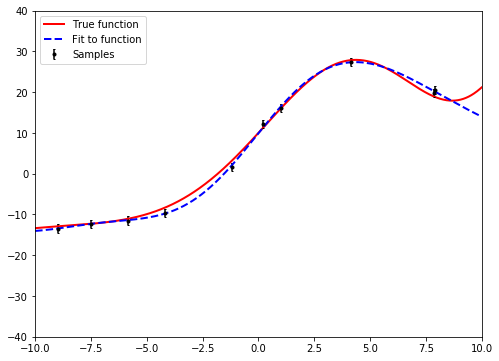

In [15]:
axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

## Support vector regression

The functional form of the trained model is the same as that of kernel ridge regression. However, the cost function used for training is called a hinge loss cost function. It is insensitive to errors smaller than $\epsilon$ and linear (instead of quadratic) outside this range. The regularization term is still quadratic.

By convention the hyperparameter $C$ in the SVR cost function is in front of the term with the data instead of the regularization term. It is essentially the inverse of the $\alpha$ quantity used in linear regression.

In [16]:
# Calculate the cross-validation error on a grid of hyperparameters

err_array = []
for C in np.logspace(-1, 4, 10):
    for epsilon in np.logspace(-3, 1, 10):
        for gamma in np.logspace(-1, 2, 10):
            reg = svm.SVR(C=C, epsilon=epsilon, kernel='rbf', gamma=gamma)
            
            nmse = model_selection.cross_val_score(reg, X_scaled, y_train, scoring='neg_mean_squared_error', cv=5) 
            cv_errors = np.sqrt(-nmse)
            err_cv = np.mean(cv_errors)
            err = [C, epsilon, gamma, err_cv]
            #print err,
            err_array.append(err)

err_array = np.array(err_array)

In [17]:
# Select hyperparameters with lowest average cross-validation error
imin = np.argmin(err_array[:, 3])
err_min = err_array[imin]
C = err_min[0]
epsilon = err_min[1]
gamma = err_min[2]
print '[C, epsilon, gamma, min error] = [{}, {}, {}, {}]'.format(C, epsilon, gamma, err_min[3])

# Fit with chosen hyperparameters
reg = svm.SVR(C=C, epsilon=epsilon, kernel='rbf', gamma=gamma)
reg.fit(X_scaled, y_train)
y_pred = reg.predict(X_pred_scaled)

[C, epsilon, gamma, min error] = [774.263682681, 0.16681005372, 10.0, 1.01488511473]


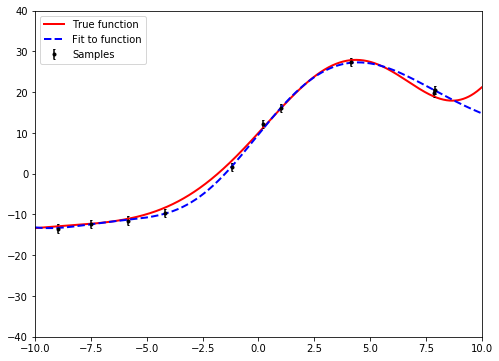

In [18]:
axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

## Gaussian process regression

GPR interprets the kernel as a covariance matrix $k(x^i, x^j)$, where each point $x^i$ is a parameter in a multivariate Gaussian distribution. The mean is the function approximation:

$\hat y_w(x) = k(x^i, x)k(x^i, x^j)^{-1}y^j$.

The cost function that is minimized to optimize the hyperparameters is the negative of the log likelihood:

$\ln p(y|x, w) = -\frac{1}{2} y^T K^{-1} y - \frac{1}{2}\ln |K| - \frac{n}{2}\ln(2\pi)$.

The first term contains the data. The second term is a regularization term. The third term is just a constant.

Feature scaling is not absolutely necessary for GPR as long as each feature has an independent length scale in the kernel. Note that the RBF kernel here does not have the same functional form as the RBF kernel for KernelRidge and SVR. The length scales $l_i^2$ are roughly the inverse of the reqularization parameter $\gamma$. Also, you don't have to use the same length scale for each parameter as shown at the end of this notebook in the 5d example.

Useful links:
 * Nice tutorial: [arXiv:1505.02965](https://arxiv.org/abs/1505.02965)
 * List of kernels in [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels).
 * More thorough list of kernels in [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) book.

### Kernel without a noise term
Without a noise term the fit is required to pass exactly through the data points. This can be a problem if the data has numerical errors.

In [19]:
kernel = ConstantKernel(2**2, (1e-3, 1e3)) * RBF(3.0, (1e-2, 1e2))

reg = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
reg.fit(X_train, y_train)

X_pred = np.atleast_2d(np.linspace(-10, 10, 1000)).T
y_pred, y_sigma = reg.predict(X_pred, return_std=True)

print 'Initial hyperparameter guess: {}'.format(reg.kernel)
print 'Optimized hyperparameters: {}'.format(reg.kernel_)

Initial hyperparameter guess: 2**2 * RBF(length_scale=3)
Optimized hyperparameters: 16.5**2 * RBF(length_scale=2.13)


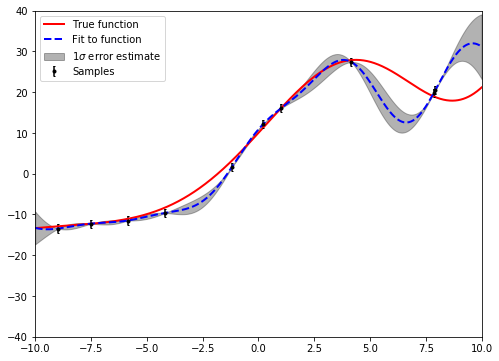

In [20]:
axes = plot_data(func, X_train, y_train, sigma)

# Fit to function
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')

# Error estimate
axes.fill_between(x_pred, y_pred-y_sigma, y_pred+y_sigma, color='k', alpha=0.3, label=r'$1\sigma$ error estimate')

axes.legend();

### Kernel with a noise term (nugget)
With the addition of a white noise term in the kernel, the fit doesn't have to pass exactly through the data point. This allows for simpler functions.

In [21]:
kernel = ConstantKernel(2**2, (1e-3, 1e3)) * RBF(3.0, (1e-2, 1e2)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-03, 1.0e1))

reg = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
reg.fit(X_train, y_train)

X_pred = np.atleast_2d(np.linspace(-10, 10, 1000)).T
y_pred, y_sigma = reg.predict(X_pred, return_std=True)

print 'Initial hyperparameter guess: {}'.format(reg.kernel)
print 'Optimized hyperparameters: {}'.format(reg.kernel_)

Initial hyperparameter guess: 2**2 * RBF(length_scale=3) + WhiteKernel(noise_level=0.1)
Optimized hyperparameters: 15.8**2 * RBF(length_scale=4.92) + WhiteKernel(noise_level=0.442)


In [27]:
# The white noise kernel gets the true noise approximately correct.
sigma_nsq = np.exp(reg.kernel_.theta[2])
sigma_n = np.sqrt(sigma_nsq)
print sigma_nsq, sigma_n

0.44249881391722606 0.6652058432675002


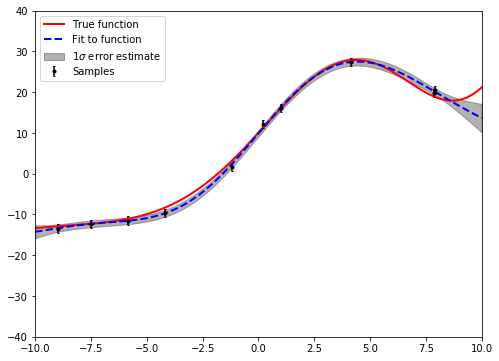

In [22]:
axes = plot_data(func, X_train, y_train, sigma)

# Fit to function
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')

# Error estimate
axes.fill_between(x_pred, y_pred-y_sigma, y_pred+y_sigma, color='k', alpha=0.3, label=r'$1\sigma$ error estimate')

axes.legend();

# Neural network (multi-layer perceptron)

A neural network is a generalization of a linear model. In each layer, each node takes as features the output from the previous layer. The output of each node is passed through an activation function, resulting in a nonlinear model. The activation from each node in the layer is then passed to each node in the next layer. Finally, the output value is a linear model of the output of the last hidden layer.

There are many kinds of activation functions. For fitting smooth functions, you probably want to use the 'logistic' (sigmoid) or 'tanh' activation functions. For many classification problems, the non-smooth 'relu' or leaky relu activation functions are faster to train and often produce better results.

The number of layers and number of nodes per layer are both hyperparameters that can be tuned. There can also be a regularization term added to the cost function. The scikit-learn version uses the standard $\mathcal{L}_2$ term (with hyperparameter $\alpha$) to limit the size of the coefficients in each of the nodes.

The scikit-learn neural network is easy to play with. For larger problems you should use TensorFlow, Keras, or one of the other libraries.

In [28]:
err_array = []
for hl1 in [10, 20, 30, 40, 50, 100]:
    for alpha in np.logspace(-7, 3, 10):
        hls = (hl1, 20)
        #hls = (hl1,)
        reg = neural_network.MLPRegressor(
            alpha=alpha, hidden_layer_sizes=hls, activation='logistic', 
            solver='lbfgs', random_state=0)
        
        nmse = model_selection.cross_val_score(reg, X_scaled, y_train, scoring='neg_mean_squared_error', cv=5) 
        cv_errors = np.sqrt(-nmse)
        err_cv = np.mean(cv_errors)
        err = [hl1, alpha, err_cv]
        #print err
        err_array.append(err)

err_array = np.array(err_array)

In [29]:
imin = np.argmin(err_array[:, 2])
err_array[imin]

array([4.00000000e+01, 3.59381366e-02, 3.47016739e+00])

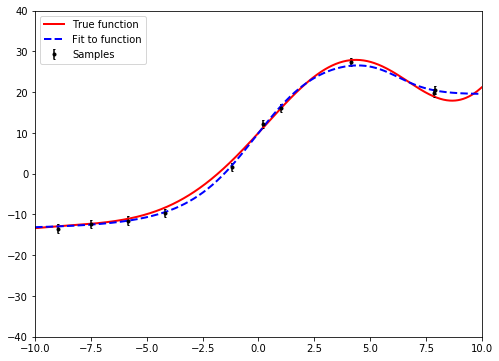

In [30]:
hls = (40, 20)
alpha = 3.59381366e-02

# hls = (100, 50, 25)
# alpha = 0

reg = neural_network.MLPRegressor(
    alpha=alpha, hidden_layer_sizes=hls, activation='logistic', 
    solver='lbfgs', random_state=0)
reg.fit(X_scaled, y_train)
y_pred = reg.predict(X_pred_scaled)

########################

axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

# Random Forests and other tree-based methods.

A Random Forest is the average of $n_{\rm estimators}$ decision trees. It is less useful for continuous, smooth functions. Because decision trees are piecewise-constant functions, methods based on them do not require feature scaling.

In [31]:
n_estimators = 20
min_samples_split = 2

err_array = []
for max_depth in [1, 2, 5, 10]:
    for min_samples_leaf in [1, 2, 5, 10]:

        reg = ensemble.RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth, 
            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
            max_features='sqrt', 
            n_jobs=-1, random_state=1)
        
        nmse = model_selection.cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5) 
        cv_errors = np.sqrt(-nmse)
        err_cv = np.mean(cv_errors)
        err = [max_depth, min_samples_leaf, err_cv]
        print err
        err_array.append(err)
        
err_array = np.array(err_array)

[1, 1, 5.549534626008581]
[1, 2, 5.980362143800721]
[1, 5, 17.088977250295354]
[1, 10, 17.088977250295354]
[2, 1, 4.4092493804687924]
[2, 2, 5.934964249900064]
[2, 5, 17.088977250295354]
[2, 10, 17.088977250295354]
[5, 1, 4.333936483161048]
[5, 2, 5.934964249900064]
[5, 5, 17.088977250295354]
[5, 10, 17.088977250295354]
[10, 1, 4.333936483161048]
[10, 2, 5.934964249900064]
[10, 5, 17.088977250295354]
[10, 10, 17.088977250295354]


In [32]:
imin = np.argmin(err_array[:, 2])
err_array[imin]

array([5.        , 1.        , 4.33393648])

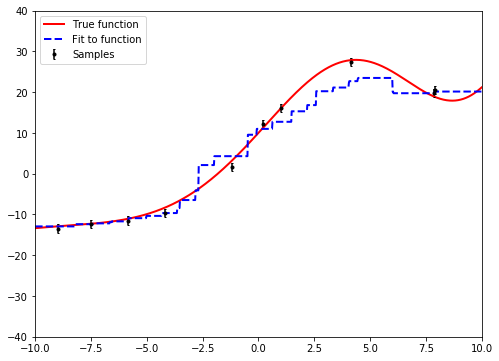

In [33]:
n_estimators = 20
max_depth = 5
min_samples_leaf = 1
min_samples_split = 2

reg = ensemble.RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
    max_features='sqrt', 
    n_jobs=-1, random_state=1)
        
reg.fit(X_train, y_train)
y_pred = reg.predict(X_pred)

########################

axes = plot_data(func, X_train, y_train, sigma)
axes.plot(x_pred, y_pred, c='b', ls='--', lw=2, label='Fit to function')
axes.legend();

# Simple 5d function with Latin hypercube sampling and GPR

In [34]:
def latin_hypercube(npoints, limits):
    """Select parameters using the Latin Hypercube method.

    Parameters
    ----------
    npoints : int
        Number of points to select.
    limits : np.array([[x0_min, x0_max], [x1_min, x1_max], [x2_min, x2_max], ...])
        Boundaries of the hypercube.
    """
    ndim = len(limits)

    # Make a list of points
    # Make sure they are floats and not ints
    points = np.array([[1.0*i]*ndim for i in range(npoints)])

    # Shuffle the values for each dimension
    for j in range(ndim):
        np.random.shuffle(points[:, j])

    # Rescale the points to match the bounds from limits
    for j in range(ndim):
        low = float(limits[j, 0])
        high = float(limits[j, 1])
        points[:, j] = low + points[:, j]*(high-low)/(npoints-1.0)

    return points

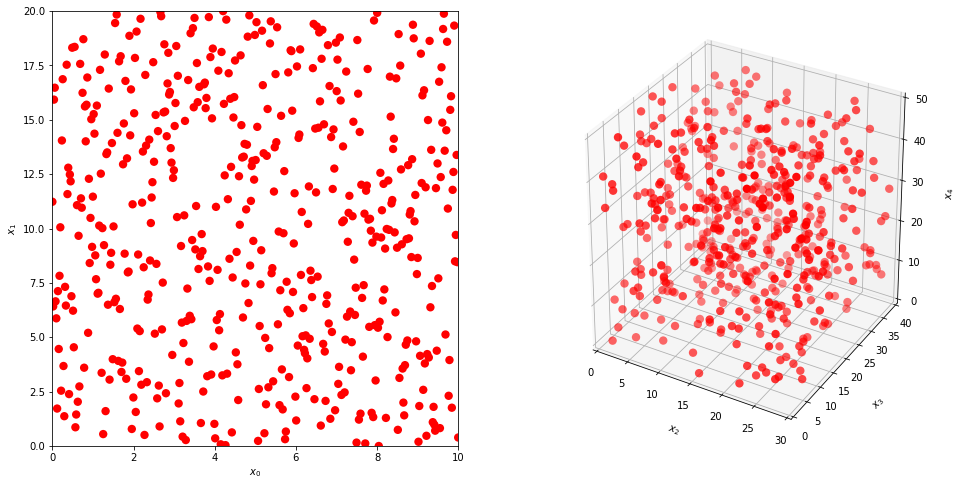

In [35]:
# Make 5d latin hypercube
nsamp = 512
limits = np.array([[0, 10], [0, 20], [0, 30], [0, 40], [0, 50]])
X_train = latin_hypercube(nsamp, limits)

# ******* plot the sample *******
fig = plt.figure(figsize=(16, 8))

axes = fig.add_subplot(121)
axes.scatter(X_train[:, 0], X_train[:, 1], c='r', edgecolor='none', marker='o', s=70)
axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

axes = fig.add_subplot(122, projection='3d')
x, y, z = X_train[:, 2], X_train[:, 3], X_train[:, 4]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlim(limits[2])
axes.set_ylim(limits[3])
axes.set_zlim(limits[4])
axes.set_xlabel(r'$x_2$', labelpad=10)
axes.set_ylabel(r'$x_3$', labelpad=15)
axes.set_zlabel(r'$x_4$', labelpad=15);

In [36]:
# True function
def func(x):
    """Function of 5 parameters x = [x0, x1, x2, x3, x4].
    """
    a = (np.sin(0.5*x[0]*(1.0+0.05*x[0])) + 0.5*x[0] + 10)*0.01*(x[1]-5.0)**2
    b = -0.1*x[0]*x[1] + 0.02*x[2]**2 + 0.02*x[3]**2 - 0.02*(x[4]-5)*x[3]
    return a + b

# Generate data and add a small noise term
sigma = 1.0e-2
nsamp = len(X_train)
y_train = np.array([func(X_train[i]) for i in range(nsamp)]) + np.random.normal(0.0, sigma, nsamp)

In [37]:
# Specify the kernel and choose the initial guess and bounds for the hyperparameters
sigma_f_square = ConstantKernel(100., (1., 500.))
sqexp = RBF((10., 10., 10., 10., 10.), ((1., 100.), (1., 100.), (1., 100.), (1., 100.), (1., 1000.)))
sigma_n_square = WhiteKernel(noise_level=1.0e-5, noise_level_bounds=(1.0e-8, 1.0e-2))
kernel = sigma_f_square * sqexp + sigma_n_square

# Fit to data and optimize the hyperparameters by maximizing the likelihood
reg = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
reg.fit(X_train, y_train)

print 'Initial hyperparameter guess: {}'.format(reg.kernel)
print 'Optimized hyperparameters: {}'.format(reg.kernel_)

Initial hyperparameter guess: 10**2 * RBF(length_scale=[10, 10, 10, 10, 10]) + WhiteKernel(noise_level=1e-05)
Optimized hyperparameters: 22.4**2 * RBF(length_scale=[4.7, 19, 55.7, 42, 117]) + WhiteKernel(noise_level=0.000164)


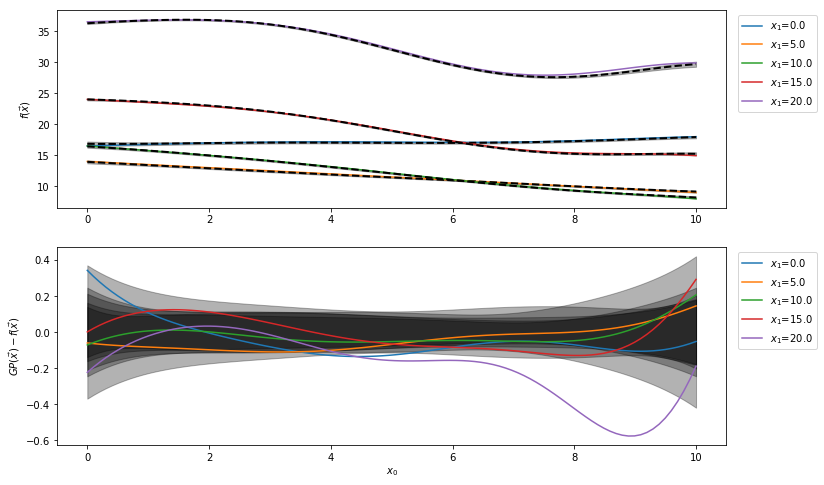

In [38]:
# Plot several 1d cross sections of the 5d function.
# The true function is solid. 
# The fit is dashed. 
# The error estimate is shaded.
x2 = 30
x3 = 40
x4 = 50

fig, ax = plt.subplots(2, figsize=(12, 8))
for x1 in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in xs])
    
    y_true = np.array([func(p) for p in ps])
    ax[0].plot(xs, y_true, label=r'$x_1$={}'.format(x1))
    
    y_pred, y_sigma = reg.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-y_sigma, y_pred+y_sigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-y_true), label=r'$x_1$={}'.format(x1))
    ax[1].fill_between(xs, -y_sigma, y_sigma, color='k', alpha=0.3)

#ax[0].
ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
ax[0].legend(bbox_to_anchor=(1.01, 1.0))
ax[1].legend(bbox_to_anchor=(1.01, 1.0));